Data ready.
Beginning training.
Training using 0% unlabeled data.
10 epochs passed.
20 epochs passed.
30 epochs passed.
Training using 20% unlabeled data.
10 epochs passed.
20 epochs passed.
30 epochs passed.
40 epochs passed.
50 epochs passed.
60 epochs passed.
70 epochs passed.
80 epochs passed.
90 epochs passed.
Training using 40% unlabeled data.
10 epochs passed.
20 epochs passed.
30 epochs passed.
40 epochs passed.
50 epochs passed.
60 epochs passed.
70 epochs passed.
80 epochs passed.
90 epochs passed.
100 epochs passed.
110 epochs passed.
120 epochs passed.
Training using 60% unlabeled data.
10 epochs passed.
20 epochs passed.
30 epochs passed.
40 epochs passed.
50 epochs passed.
60 epochs passed.
70 epochs passed.
80 epochs passed.
90 epochs passed.
100 epochs passed.
110 epochs passed.
120 epochs passed.
Training using 80% unlabeled data.
10 epochs passed.
20 epochs passed.
30 epochs passed.
40 epochs passed.
50 epochs passed.
60 epochs passed.
70 epochs passed.
80 epochs pass

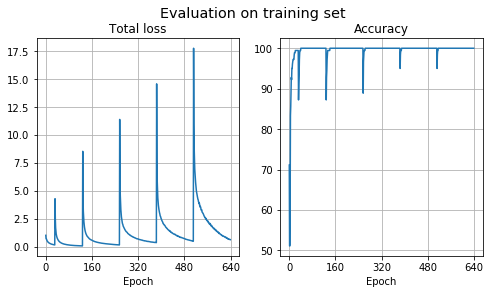

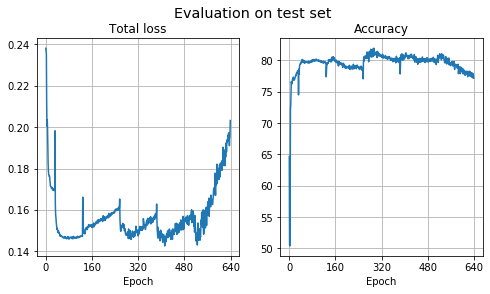

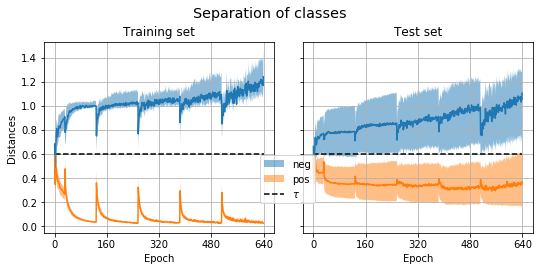

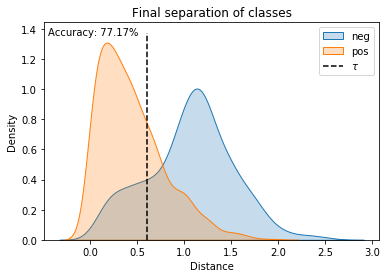

Maximal accuracy: 81.94% (epoch 293).


In [1]:
import itertools as it

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from cl.mnist import PseudolabelSNN
from data import SiameseMNIST as Dataset
from criterions import ModifiedCrossEntropy, ContrastiveLoss


device = "cuda" if torch.cuda.is_available() else "cpu"


def test(T):
    train_log["pos_dists"].append([])
    train_log["neg_dists"].append([])
    test_log["total_loss"].append(0.0)
    test_log["pos_dists"].append([])
    test_log["neg_dists"].append([])

    net.eval()
    with torch.no_grad():
        # evaluation on training set
        total = correct = 0
        for tensors in train_loader:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net(images1, images2)

            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()
            correct += torch.isclose(labels.squeeze(), preds).sum().item()
            total += preds.shape[0]
            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    train_log["pos_dists"][-1].append(dist.item())
                else:
                    train_log["neg_dists"][-1].append(dist.item())

        accuracy = 100 * correct / total
        train_log["accuracy"].append(accuracy)

        # evaluation on test set
        total = correct = 0
        for tensors in test_loader:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net(images1, images2)
            
            loss = criterion(outputs1, outputs2, labels.squeeze())
            test_log["total_loss"][-1] += loss.item()

            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()
            correct += torch.isclose(labels.squeeze(), preds).sum().item()
            total += preds.shape[0]
            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    test_log["pos_dists"][-1].append(dist.item())
                else:
                    test_log["neg_dists"][-1].append(dist.item())
        accuracy = 100 * correct / total
        test_log["accuracy"].append(accuracy)


def train(E, T, p):
    for i in range(E):
        if i != 0 and i % 10 == 0:
            print(f"{i} epochs passed.")

        # logs
        train_log["total_loss"].append(0.0)

        net.train()
        if p > 0:
            for (images1, images2, labels), (images3, images4, p_labels) in zip(it.cycle(train_loader), pseudo_loader):
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
                images3, images4, p_labels = images3.to(device), images4.to(device), p_labels.to(device)
                
                outputs1, outputs2 = net(images1, images2)
                outputs3, outputs4 = net(images3, images4)
                loss = criterion(outputs1, outputs2, labels.squeeze()) +  criterion(outputs3, outputs4, p_labels.squeeze())

                train_log["total_loss"][-1] += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        else:
            for tensors in train_loader:
                images1, images2, labels = (t.to(device) for t in tensors)
                outputs1, outputs2 = net(images1, images2)
                loss = criterion(outputs1, outputs2, labels.squeeze())

                train_log["total_loss"][-1] += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        test(T)


def show_results():
    E = sum(Es)

    # summary - training
    print("Summary of training")
    start = 0  # the first epoch to be taken into consideration
    k = 4
    domain = range(start, E)
    ticks = list(range(start, E + 1, (E - start) // k)) 

    max_len = len(train_log["pos_dists"][-1])
    train_log["pos_dists"] = [l + [np.nan for _ in range(len(l), max_len)] for l in train_log["pos_dists"]]
    max_len = len(train_log["neg_dists"][-1])
    train_log["neg_dists"] = [l + [np.nan for _ in range(len(l), max_len)] for l in train_log["neg_dists"]]

    train_pos_dists = np.array(train_log["pos_dists"][start:])
    train_neg_dists = np.array(train_log["neg_dists"][start:])
    test_pos_dists = np.array(test_log["pos_dists"][start:])
    test_neg_dists = np.array(test_log["neg_dists"][start:])

    # on training set
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
    fig.suptitle("Evaluation on training set", y=0.99, fontsize="x-large")

    axs[0].plot(domain, train_log["total_loss"][start:])
    axs[0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
    axs[0].grid()

    axs[1].plot(domain, train_log["accuracy"][start:])
    axs[1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
    axs[1].grid()

    plt.show()

    # on test set
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
    fig.suptitle("Evaluation on test set", y=0.99, fontsize="x-large")

    axs[0].plot(domain, test_log["total_loss"][start:])
    axs[0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
    axs[0].grid()

    axs[1].plot(domain, test_log["accuracy"][start:])
    axs[1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
    axs[1].grid()

    plt.show()

    # separation of classes throughout training
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    fig.suptitle("Separation of classes", fontsize="x-large")

    axs[0].set(title="Training set", xlabel="Epoch", ylabel="Distances", xticks=ticks)
    axs[0].grid()

    q25, q50, q75 = np.nanpercentile(train_neg_dists, [25, 50, 75], axis=1)
    axs[0].plot(domain, q50)
    axs[0].fill_between(domain, q75, q25, alpha=0.5, label="neg")

    q25, q50, q75 = np.nanpercentile(train_pos_dists, [25, 50, 75], axis=1)
    axs[0].plot(domain, q50)
    axs[0].fill_between(domain, q75, q25, alpha=0.5, label="pos")

    axs[0].hlines(T, start, E, label="$\\tau$", linestyles="--")

    axs[1].set(title="Test set", xlabel="Epoch", xticks=ticks)
    axs[1].grid()

    q25, q50, q75 = np.nanpercentile(test_neg_dists, [25, 50, 75], axis=1)
    axs[1].plot(domain, q50)
    axs[1].fill_between(domain, q75, q25, alpha=0.5)

    q25, q50, q75 = np.nanpercentile(test_pos_dists, [25, 50, 75], axis=1)
    axs[1].plot(domain, q50)
    axs[1].fill_between(domain, q75, q25, alpha=0.5)

    axs[1].hlines(T, start, E, linestyles="--")

    fig.tight_layout(pad=2.5)
    fig.legend(loc=(0.482, 0.25))

    plt.show()

    # final model
    plt.title("Final separation of classes")
    sns.kdeplot(test_log["neg_dists"][-1], fill=True, label="neg")
    sns.kdeplot(test_log["pos_dists"][-1], fill=True, label="pos")
    plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
    plt.text(
        0.01,
        0.94,
        f"Accuracy: {test_log['accuracy'][-1]:.2f}%",
        transform=plt.gca().transAxes,
    )
    plt.xlabel("Distance")
    plt.legend()
    plt.show()

    print(f"Maximal accuracy: {np.max(test_log['accuracy']):.2f}% (epoch {np.argmax(test_log['accuracy'])}).")


def relabel(p, T):
    net.eval()
    with torch.no_grad():
        dists = np.array([])
        for images1, images2 in unlabeled_loader:
            images1, images2 = images1.to(device), images2.to(device)
            outputs1, outputs2 = net(images1, images2)
            dists = np.append(dists, F.pairwise_distance(outputs1, outputs2).cpu().numpy())
    
    predictions = (dists <= T).astype("float32")
    indexes = np.argsort(dists)
    bp = int(len(indexes) * p / 2)
    to_pseudolabel = np.append(indexes[:bp], indexes[-bp:])
    new_train = [(dataset.unlabeled[ix][0], dataset.unlabeled[ix][1], torch.tensor([predictions[ix]])) for ix in to_pseudolabel]
    return new_train


# load data and prepare it
dataset = Dataset()
dataset.sample_traintest()
dataset.sample_unlabeled(20)

batch_size = 60
train_loader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size, shuffle=True)
unlabeled_loader = torch.utils.data.DataLoader(dataset.unlabeled, batch_size=len(dataset.unlabeled))
test_loader = torch.utils.data.DataLoader(dataset.testset, batch_size=len(dataset.testset))
print("Data ready.")

criterion = ContrastiveLoss(margin=1.0)

# logs
train_log = {
    "total_loss": [],  # total loss
    "accuracy": [],  # accuracy
    "pos_dists": [],  # predicted distances between positive pairs
    "neg_dists": [],  # predicted distances between negative pairs
}

test_log = {
    "total_loss": [],
    "accuracy": [],
    "pos_dists": [],
    "neg_dists": [],
}

print("Beginning training.")
lr = 0.005
Es = [32, 96, 128, 128, 128, 128]
T = 0.6
dp = 1 / 5
p = 0
i = 0
while p <= (len(Es) - 1) * dp:
    if p > 0:
        pseudoset = relabel(p, T)
        pseudo_loader = torch.utils.data.DataLoader(pseudoset, batch_size=batch_size, shuffle=True)

    net = PseudolabelSNN().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    print(f"Training using {p:.0%} unlabeled data.")
    train(Es[i], T, p)

    p += dp
    i += 1


print("Training finished.\n")
show_results()

# 3, 3, [12, 12], 24, 48, 1/5
